# Algotytmy wizualizujące algorytmy tworzenia otoczki wypukłej

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bitalg.visualizer.main import Visualizer
from functools import cmp_to_key

## Wczytywanie, zapisywanie zbiorów punktów do plikow

In [33]:
def save_points(f_path, points):
    with open(f_path, "w") as f:
        f.write(f'{points}')

def load_points(f_path):
    with open(f_path, "r") as f:
        return eval(f.readlines()[0])

## Funkcje wyznacznika, orientacji oraz odległości

In [34]:
def det(a, b, c):
    return ((b[0] - a[0]) * (c[1] - b[1]) - (b[1]-a[1]) * (c[0] - b[0]) )

def points_orientation(a, b, c, eps = 0):
    computed_det = det(a, b, c)
    if computed_det > eps: return 1 #counter-clockwise turn
    elif computed_det < -eps: return -1
    return 0

def points_distance_square(a, b):
    return ((a[0]-b[0])**2 + (a[1]-b[1])**2)

## Visualizer

In [98]:
class Visualiser_embed:
    def __init__(self):
        self.v = Visualizer()
        self.ch_points = []
        self.ch_points_coords = []
        self.ch_lines = []
        self.colors = ['green', 'blue', 'cyan', 'magenta', 'yellow', 'black']
        self.points = dict()
        self.lines = dict()
        self.point_groups = []
        self.line_groups = []

    def add_points(self, points, color_no = 2):
        self.point_groups.append(self.v.add_point(points, color = self.colors[color_no%len(self.colors)]))

    def add_lines(self, lines, color_no = 2):
        self.line_groups.append(self.v.add_line_segment(lines, color = self.colors[color_no%len(self.colors)]))
    
    def add_ch_line(self, color_no = 0):
        if len(self.ch_points) > 1:
           self.ch_lines.append(self.v.add_line_segment((self.ch_points_coords[-1], self.ch_points_coords[-2]), color = self.colors[color_no%len(self.colors)]))

    def checker_line(self, line):
        x = self.v.add_line_segment(line, color = 'green')
        self.v.remove_figure(x)

    def remove_ch_line(self):
        if len(self.ch_lines):
            self.v.remove_figure(self.ch_lines.pop())

    def add_ch_point(self, point, color_no = 0):
        self.ch_points.append(self.v.add_point(point, color = self.colors[color_no%len(self.colors)]))
        self.ch_points_coords.append(point)

    def remove_ch_point(self):
        if len(self.ch_points):
            self.v.remove_figure(self.ch_points.pop())
            self.ch_points_coords.pop()
    
    def add_ending_line_and_pause_gif(self, color_no = 0):
         if len(self.ch_points) > 1:
            for _ in range(5): self.ch_lines.append(self.v.add_line_segment((self.ch_points_coords[-1], self.ch_points_coords[0]), color = self.colors[color_no%len(self.colors)]))
    
    def add_point(self, point, color_no):
        if point in self.points: self.points[point].append(self.v.add_point(point, color = self.colors[color_no%len(self.colors)]))
        else: self.points[point] = [self.v.add_point(point, color = self.colors[color_no%len(self.colors)])]
    
    def add_line(self, line, color_no):
        if line in self.lines: self.lines[line].append(self.v.add_line(line, color = self.colors[color_no%len(self.colors)]))
        else: self.lines[line] = [self.v.add_line(line, color = self.colors[color_no%len(self.colors)])]
    
    def remove_point(self, point):
        self.points.pop(point)

    def remove_line(self, line):
        self.lines.pop(line)

    def clear(self):
        for x in self.ch_points: self.v.remove_figure(x)
        for x in self.ch_lines: self.v.remove_figure(x)
        for x in self.line_groups: self.v.remove_figure(x)
        for x in self.point_groups: self.v.remove_figure(x)
        for x, y in self.points: 
            for z in y : self.v.remove_figure(z)
        for x, y in self.lines: 
            for z in y : self.v.remove_figure(z)
        self.ch_points = []
        self.ch_points_coords = []
        self.ch_lines = []
        self.points = dict()
        self.lines = dict()
        self.point_groups = []

## Algorytmy wizualizacji znajdowania otoczki wypukłej

Wszyskie zaimplementowane poniżej algorytmy przyjmują listę punktów w postaci [(x1, y1)...] oraz zwracają listę kolejnych punktów otoczki postaci [(x1, y1)...] oraz obiekt Visualizer z pakietu bit-alg.

### Algorytm Grahama

In [36]:
def graham_algorithm(points, vis = None, color_no = 4):
    V = Visualiser_embed() if not vis else vis; V.add_points(points, color_no) #
    lowest_y_point = points[0]

    for i in range(len(points)): 
        if points[i][1] < lowest_y_point[1] or (points[i][1] == lowest_y_point[1] and points[i][0] < lowest_y_point[0]): lowest_y_point = points[i] 

    def side_comp(x, y):
        orientation = points_orientation(lowest_y_point, x, y)
        if orientation == 0: return points_distance_square(lowest_y_point, x) - points_distance_square(lowest_y_point, y)
        return -orientation

    points.sort(key=cmp_to_key(side_comp))

    new_points = [lowest_y_point]

    for i in range(1, len(points)):
        if i == len(points)-1 or points_orientation(lowest_y_point, points[i], points[i+1]) != 0: new_points.append(points[i])

    S = [new_points[0]]; V.add_ch_point(new_points[0]) #
    
    for i in range(1, len(new_points)):
        while len(S) > 1 and points_orientation(S[-2], S[-1], new_points[i]) != 1: S.pop(); V.remove_ch_line(); V.remove_ch_point()

        S.append(new_points[i]); V.add_ch_point(new_points[i], (color_no + 1) % (len(V.colors) -1) + 1); V.add_ch_line((color_no + 1) % (len(V.colors) -1) + 1) #

    V.add_ending_line_and_pause_gif() #
    return (S, V)

### Algorytm Jarvisa

In [37]:
def jarvis_algorithm(points, vis = None):
    V = Visualiser_embed() if not vis else vis; V.add_points(points) #

    on_chain = points[0]
    for i in range(len(points)): 
        if points[i][1] < on_chain[1] or (points[i][1] == on_chain[1] and points[i][0] < on_chain[0]): on_chain = points[i] 

    S = []; V.add_ch_point(on_chain) #
    while not S or on_chain != S[0]:
        S.append(on_chain); V.add_ch_line(); #
        next = points[0]; V.add_ch_point(next) #
        for point in points: 
            if next == on_chain or points_orientation(on_chain, next, point) == -1 or (points_orientation(on_chain, next, point) == 0 and points_distance_square(on_chain, next)< points_distance_square(on_chain, point)):
                next = point; V.remove_ch_point(); V.add_ch_point(next) #
        on_chain = next

    V.remove_ch_point(); V.add_ending_line_and_pause_gif() #
    return (S, V)

### Algorytm Dziel i Zwyciężaj

In [47]:
# Driver code
def divide_and_conquer(points):
    points = sorted(points)
    new_points = [points[0]]
    for i in range(1, len(points) - 1):
        if points[i][0] != points[i-1][0] or points[i][0] != points[i+1][0]: new_points.append(points[i])
    
    new_points.append(points[-1])

    return divide_and_conquer_main_func(new_points)

# Main function
def divide_and_conquer_main_func(points):
    if len(points) <= 5: return jarvis_algorithm(points)[0]

    left_part = divide_and_conquer_main_func(points[:len(points)//2 + 2])
    right_part = divide_and_conquer_main_func(points[len(points)//2 + 2:])

    return merge(left_part, right_part)

# Merge function
def merge(a, b):

    if len(a) == 0: return b
    elif len(b) == 0: return a

    max_right_ind = 0
    for i in range(len(a)): 
        if a[i][0] > a[max_right_ind][0]: max_right_ind = i 

    max_left_ind = 0
    for i in range(len(b)): 
        if b[i][0] < b[max_left_ind][0]: max_left_ind = i 

    top_a_ind = bottom_a_ind = max_right_ind
    top_b_ind = bottom_b_ind = max_left_ind

 
    while True:
        done = True
        while len(a) > 1 and points_orientation(b[top_b_ind], a[top_a_ind], a[(top_a_ind + 1)%len(a)]) == -1 or (points_orientation(b[top_b_ind], a[top_a_ind], a[(top_a_ind + 1)%len(a)]) == 0 and points_distance_square(b[top_b_ind], a[top_a_ind]) < points_distance_square(b[top_b_ind], a[(top_a_ind + 1)%len(a)])): 
            top_a_ind = (top_a_ind + 1)%len(a)

        while len(b) > 1 and points_orientation(a[top_a_ind], b[top_b_ind], b[(top_b_ind - 1 + len(b))%len(b)]) == 1 or (points_orientation(a[top_a_ind], b[top_b_ind], b[(top_b_ind - 1 + len(b))%len(b)]) == 0 and points_distance_square(b[top_b_ind], a[top_a_ind]) < points_distance_square(b[(top_b_ind - 1 + len(b))%len(b)], a[top_a_ind])): 
            top_b_ind = (top_b_ind - 1 + len(b))%len(b)
            done = False
            
        if done: break
        
    while True:
        done = True
        while len(a) > 1 and points_orientation(b[bottom_b_ind], a[bottom_a_ind], a[(bottom_a_ind - 1 + len(a))%len(a)]) == 1 or (points_orientation(b[bottom_b_ind], a[bottom_a_ind], a[(bottom_a_ind - 1 + len(a))%len(a)]) == 0 and points_distance_square(b[bottom_b_ind], a[bottom_a_ind]) < points_distance_square(b[bottom_b_ind], a[(bottom_a_ind - 1 + len(a))%len(a)])): 
            bottom_a_ind = (bottom_a_ind - 1 + len(a))%len(a)

        while len(b) > 1 and points_orientation(a[bottom_a_ind], b[bottom_b_ind], b[(bottom_b_ind + 1)%len(b)]) == -1 or (points_orientation(a[bottom_a_ind], b[bottom_b_ind], b[(bottom_b_ind + 1)%len(b)]) == 0 and points_distance_square(b[bottom_b_ind], a[bottom_a_ind]) < points_distance_square(b[(bottom_b_ind + 1)%len(b)], a[bottom_a_ind])): 
            bottom_b_ind = (bottom_b_ind + 1)%len(b)
            done = False

        if done: break

    new_points = []
    i = top_a_ind
    while i != bottom_a_ind: 
        new_points.append(a[i])
        i = (i + 1) % len(a)
    new_points.append(a[bottom_a_ind])

    i = bottom_b_ind
    while i != top_b_ind: 
        new_points.append(b[i])
        i = (i + 1) % len(b)
    new_points.append(b[top_b_ind])

    return new_points

### Algorytm Chana

In [329]:
def chan_algorithm(points):

    V = Visualizer()
    V.add_point(points)

    added_elements = []

    def most_acute(hull, a):
        left_before = points_orientation(a, hull[(len(hull) - 1) % len(hull)], hull[0])
        left_after = points_orientation(a, hull[0], hull[1% len(hull)])
        if left_before == 0 and left_after == 0: return hull[0] if points_distance_square(a, hull[0]) > points_distance_square(a, hull[1 %len(hull)]) else hull[1 % len(hull)]
        for x in range(len(hull)):
            mid_before = points_orientation(a, hull[(x + len(hull) - 1) % len(hull)], hull[x])
            mid_after = points_orientation(a, hull[x], hull[(x + 1) % len(hull)])
            if mid_after == 1 and (mid_before == 0 or mid_before == -1): 
                return hull[x]
	

    min_y_ind = 0
    for i in range(len(points)):
        if points[i][1] < points[min_y_ind][1]: min_y_ind = i

    for t in range(len(points)):
        while added_elements: V.remove_figure(added_elements.pop())
        m = min(2 ** t, len(points))
        hulls = [graham_algorithm(points[i * m:i * m +m])[0] for i in range((len(points)+m-1)//m)] 
        colors = ['blue', 'magenta', 'black', 'green', 'orange', 'yellow', 'pink', 'purple', 'cyan', 'brown']
        for i in range(len(hulls)): 
            added_elements.append(V.add_point(points[i * m:i * m +m], color = colors[i%len(colors)]))
            hull_sides = []
            for j in range(len(hulls[i])):
                hull_sides.append((hulls[i][j], hulls[i][(j+1)%len(hulls[i])]))
            added_elements.append(V.add_line_segment(hull_sides, color = colors[i%len(colors)]))
            
            
        if len(hulls) == 1:  
            hull_sides = []
            for j in range(len(hulls[0])):
                hull_sides.append((hulls[0][j], hulls[0][(j+1)%len(hulls[0])]))
            added_elements.append(V.add_line_segment(hull_sides, color = colors[0%len(colors)]))
            return hulls[0], V

        ans_hull = [] 
        on_chain = points[min_y_ind]

        # pseudo jarvis
        for i in range(m):
            if i > 0: V.remove_figure(added_elements.pop())
            ans_hull.append(on_chain); added_elements.append(V.add_point(on_chain, color = 'red')); added_elements.append(V.add_line_segment((ans_hull[len(ans_hull)-1], ans_hull[(2*len(ans_hull)-2)%len(ans_hull)]), color = 'red'))
            next = most_acute(hulls[0], on_chain); added_elements.append(V.add_line_segment((ans_hull[-1], next), color = 'green'))
            for j in range(1, len(hulls)):
                candidate = most_acute(hulls[j], on_chain)
                if points_orientation(on_chain, next, candidate) == -1 or (points_orientation(on_chain, next, candidate) == 0 and points_distance_square(on_chain, next) < points_distance_square(on_chain, candidate)):
                    next = candidate
                    V.remove_figure(added_elements.pop())
                    added_elements.append(V.add_line_segment((ans_hull[-1], next), color = 'green'))
                    
            on_chain = next
            if on_chain == points[min_y_ind]: return ans_hull, V

    return [], V

Lab 2, task 2:
	Test 1: 5
zboj
Passed
	Test 2: 1
chuj 0
Passed
	Test 3: 2
chuj 1
Passed
	Test 4: 5
zboj
Passed
	Test 5: 1000
zboj
WRONG ANSWER
		Output:   [(0.00022143953625450066, -0.9999999754822656), (0.0018310907166059663, -0.9999983235519886), (0.004674316600857559, -0.9999890753224832), (0.005440630206227845, -0.9999851996619545), (0.009618119447759222, -0.9999537448193735), (0.020715290007359437, -0.9997854153566709), (0.021967448410721985, -0.9997586864890559), (0.027776914597739028, -0.99961...
		Expected: [(0.07000085966667666, -0.9975469310493248), (0.1380455179058054, -0.9904258856603648), (0.1424763509767261, -0.9897982064099514), (0.15459183329796522, -0.9879784233866518), (0.1639978958115513, -0.9864606886082099), (0.1670602636719769, -0.9859466863384904), (0.16769119087644196, -0.9858395734106238), (0.17337673263098613, -0.9848555775250519), (...
	Test 6: 10000
zboj
WRONG ANSWER
		Output:   [(5.540700064157875, -99.99151019434179), (98.36082104462892, -99.9365882642427)

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7fc1f703e940> (for post_execute):


KeyboardInterrupt: 

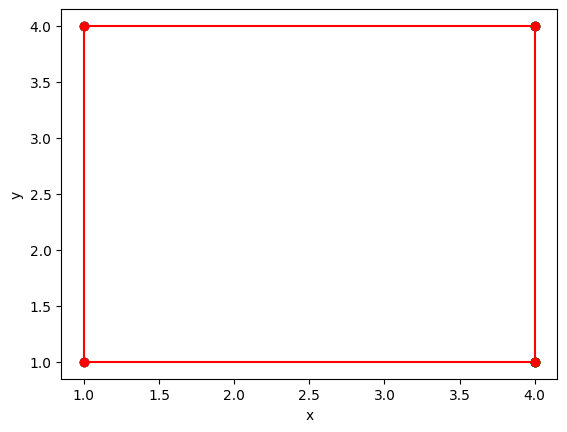

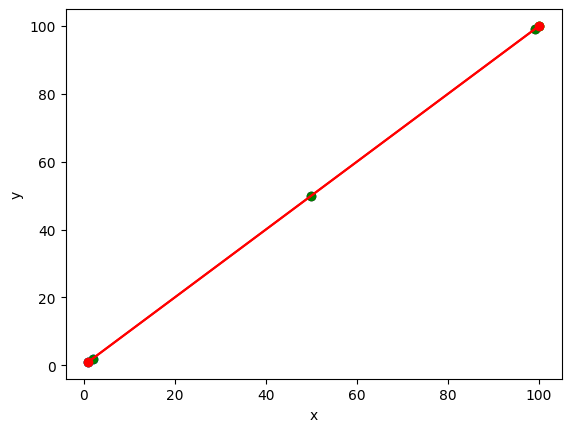

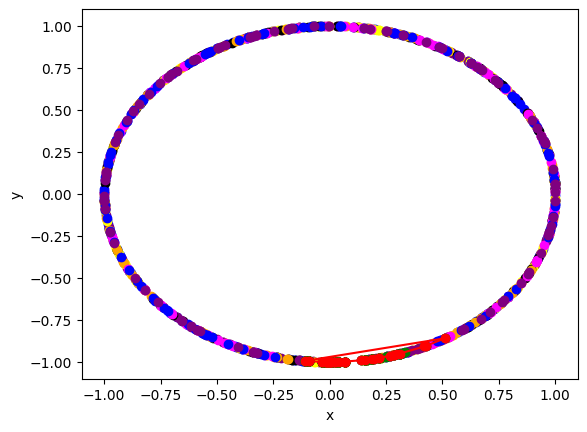

Error in callback <function flush_figures at 0x7fc1f69020d0> (for post_execute):


KeyboardInterrupt: 

### Algorytm przyrostowy

In [482]:
class Node:
    def __init__(self, point):
        self.point = point
        self.prev = None
        self.next = None

class DoublyLinkedList:
    def __init__(self):
        self.head = None
        self.tail = None

    def append(self, point, other = None):
        new_node = Node(point)
        if not self.head:
            self.head = new_node
            self.tail = new_node
        elif not other or other == self.tail:
            new_node.prev = self.tail
            self.tail.next = new_node
            self.tail = new_node
        else:
            new_node.next = other.next
            new_node.prev = other
            other.next.prev = new_node
            other.next = new_node

        return new_node

    def prepend(self, point, other = None):
        new_node = Node(point)
        if not self.head:
            self.head = new_node
            self.tail = new_node
        elif not other or other == self.head:
            new_node.next = self.head
            self.head.prev = new_node
            self.head = new_node
        else:
            new_node.next = other
            new_node.prev = other.prev
            other.prev.next = new_node
            other.prev = new_node
        
        return new_node
    
    def get_next(self, other):
        if other == None: return None
        if other == self.tail: return self.head
        return other.next

    def get_prv(self, other):
        if other == None: return None
        if other == self.head: return self.tail
        return other.prev

    def delete(self, other, V, VD):
        if self.head == self.tail and self.head == other: 
            self.head = self.tail = None

        remove_point_from_V(V, VD, other.point)

        if other == self.head:
            self.head = self.head.next
            self.head.prev = None
        elif other == self.tail:
            self.tail = self.tail.prev
            self.tail.next = None
        else: 
            other.prev.next = other.next
            other.next.prev = other.prev
            other.next = other.prev = None

        if self.head == None or self.tail == None:
            self.head = self.tail = None

    def to_list(self):
        current = self.head
        ans = []
        while current:
            ans.append(current.point)
            current = current.next
        return ans
    
    def amend_the_hull(self, point, other, V, VD):
        add_point_to_V(V, VD, point)
        c1 = c2 = other
        to_be_deleted = []
        
        while points_orientation(point, c1.point, self.get_next(c1).point) == -1 or (points_orientation(point, c1.point, self.get_next(c1).point) == 0 and points_distance_square(point, c1.point) < points_distance_square(point, self.get_next(c1).point)):
            if c1 != other: 
                to_be_deleted.append(c1)
            c1 = self.get_next(c1)

        while points_orientation(point, c2.point, self.get_prv(c2).point) == 1 or (points_orientation(point, c2.point, self.get_prv(c2).point) == 0 and points_distance_square(point, c2.point) < points_distance_square(point, self.get_prv(c2).point)):
            if c2 != other: 
                to_be_deleted.append(c2)
            c2 = self.get_prv(c2)

        if c1 != other and c2 != other:
            to_be_deleted.append(other)

          
        
        for x in to_be_deleted: self.delete(x, V, VD)


        a=V.add_line_segment([(c1.point, point), (c2.point, point)], color='green')

        V.remove_figure(a)


        zzzzz= self.prepend(point, c1)

        if self.get_next(c1) != c2:
            remove_segment_from_V(V, VD, (c1.point, c2.point))

        add_segment_to_V(V, VD, (c1.point, point))
        add_segment_to_V(V, VD, (c2.point, point))

        
        return zzzzz
    

def add_segment_to_V(V, VD, new_points, color = 'red'):
        VD[(min(new_points[0], new_points[1]), max(new_points[0], new_points[1]))] = V.add_line_segment((min(new_points[0], new_points[1]), max(new_points[0], new_points[1])), color = color)

def add_point_to_V(V, VD, newpoint, color = 'red'):
    VD[newpoint] = V.add_point(newpoint, color = color)

def remove_point_from_V(V, VD, point):
    V.remove_figure(VD[point])  
    del VD[point]

def remove_segment_from_V(V, VD, point):
    if (min(point[0], point[1]), max(point[0], point[1])) in VD:
        V.remove_figure(VD[(min(point[0], point[1]), max(point[0], point[1]))])  
        del VD[(min(point[0], point[1]), max(point[0], point[1]))]

def incremental(points):

    V = Visualizer()
    VD = dict()
    V.add_point(points)
    if len(points) < 2: return points, V 

    points = sorted(points)

    new_points = [points[0]]
    old_points = []
    for i in range(1, len(points) - 1):
        if points[i][0] != points[i-1][0] or points[i][0] != points[i+1][0]: 
            new_points.append(points[i])
        else: old_points.append(points[i])
    
    V.add_point(old_points, color = 'white')
    
    new_points.append(points[-1])
    
    CH = DoublyLinkedList()
    CH.append(new_points[0])
    added_last = CH.append(new_points[1])
    add_segment_to_V(V, VD, (new_points[0], new_points[1]))
    add_point_to_V(V, VD, new_points[0])
    add_point_to_V(V, VD, new_points[1])

    for i in range(2, len(new_points)): 
        added_last = CH.amend_the_hull(new_points[i], added_last, V, VD)
        to_be_deldel = []
        for key in VD:
            if isinstance(key, tuple) and isinstance(key[0], tuple):
                if key[0] not in VD or key[1] not in VD:
                    to_be_deldel.append(key)
        for aa in to_be_deldel: remove_segment_from_V(V, VD, aa)
        
    return CH.to_list(), V   

### Algorytm QuickHull

In [170]:
#dystans punktu p od linii, ktora laczy punkty a i b

def distance(a,b,p):
    return abs((p[1]-a[1])*(b[0]-a[0]) - (b[1]-a[1])*(p[0]-a[0]))

def recur(a, b, p, ch, points):
    right = []
    if(len(p)==0):
        return
    #wyznaczam punkty po prawej stronie prostej ab
    for i in range(len(p)): 
        if(points_orientation(a, b, p[i]) == -1):
            right.append(p[i])

    #wyznaczam punkt najdalej lezacy od prostej ab
    if(len(right)==0):
        return 
    
    else:
        dist = -1
        for i in range(len(right)):
            if distance(a,b,right[i]) > dist:
                index = i
                dist = distance(a,b,right[i])

        a_ind = ch.index(a)
        new_p = right[index]
        ch.insert(a_ind+1, new_p)
        recur(a, new_p, right, ch, points)
        recur(new_p, b, right, ch, points)    
    
def Quickhull(points):
    if len(points) < 2: return points
    ch = [] 

    a = min(points)
    b = max(points)   

    ch.append(a)
    ch.append(b)
    
    recur(a,b,points,ch,points)
    recur(b,a,points,ch,points)
    
    return ch

### Algorytm Upper-Lower

In [42]:
   
def UpperAndLower(points):
    if len(points) < 3: return points
    sorted_points = sorted(points, key=lambda x: (x[0], x[1]))

    upper, lower = [sorted_points[0], sorted_points[1]], [sorted_points[0], sorted_points[1]]

    for idx in range(2, len(sorted_points)):
        while len(upper) > 1 and points_orientation(upper[-2], upper[-1], sorted_points[idx]) != -1:
            upper.pop()
        upper.append(sorted_points[idx])     

        while len(lower) > 1 and points_orientation(lower[-2], lower[-1], sorted_points[idx]) != 1:
            lower.pop()
        lower.append(sorted_points[idx])
    lower.reverse()
    
    upper.pop()
    lower.pop()
    
    hull = lower + upper
    
    return list(reversed(hull))


[(0, 0), (0, 1.7973882603514757), (0, 2.0752403541505116), (0, 2.2185340801627396), (0, 2.6608040616600004), (0, 3.9393132458181257), (0, 4.500955174019103), (0, 6.10381997122909), (0, 7.613834400777135), (0, 8.50580304623626), (0, 9.490032788769971), (0, 10), (0.19966653659046707, 9.800333463409533), (1.1438086484599874, 8.856191351540012), (1.3082355490525677, 0), (1.5427484638692945, 1.5427484638692945), (1.5885826456879937, 0), (2.1837136463347817, 7.816286353665218), (2.196383939445521, 2.196383939445521), (2.5591114308476373, 0), (2.643793302924764, 2.643793302924764), (2.6980706555319376, 2.6980706555319376), (2.7871011015218237, 0), (2.8103133828068483, 7.189686617193152), (2.944724966178429, 7.055275033821571), (3.9525641380748233, 0), (4.07851557705991, 5.92148442294009), (4.142520093348764, 4.142520093348764), (4.7312824099383635, 0), (5.099125014270967, 0), (6.330742379366302, 3.669257620633698), (6.38058017203766, 3.61941982796234), (6.584595708497838, 6.584595708497838), 

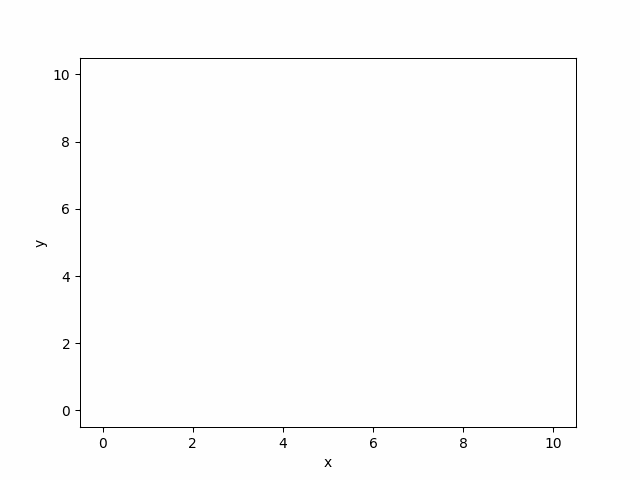

In [484]:
#TMP SYF

points = [(0, 0), (0, 1.7973882603514757), (0, 2.0752403541505116), (0, 2.2185340801627396), (0, 2.6608040616600004), (0, 3.9393132458181257), (0, 4.500955174019103), (0, 6.10381997122909), (0, 7.613834400777135), (0, 8.50580304623626), (0, 9.490032788769971), (0, 10), (0.19966653659046707, 9.800333463409533), (1.1438086484599874, 8.856191351540012), (1.3082355490525677, 0), (1.5427484638692945, 1.5427484638692945), (1.5885826456879937, 0), (2.1837136463347817, 7.816286353665218), (2.196383939445521, 2.196383939445521), (2.5591114308476373, 0), (2.643793302924764, 2.643793302924764), (2.6980706555319376, 2.6980706555319376), (2.7871011015218237, 0), (2.8103133828068483, 7.189686617193152), (2.944724966178429, 7.055275033821571), (3.9525641380748233, 0), (4.07851557705991, 5.92148442294009), (4.142520093348764, 4.142520093348764), (4.7312824099383635, 0), (5.099125014270967, 0), (6.330742379366302, 3.669257620633698), (6.38058017203766, 3.61941982796234), (6.584595708497838, 6.584595708497838), (6.606480696570816, 6.606480696570816), (6.71771023223844, 3.2822897677615597), (7.246855577824873, 0), (7.718160744943332, 7.718160744943332), (7.884652129621108, 7.884652129621108), (7.964150626275728, 0), (8.031189732051807, 0), (8.41506433861673, 8.41506433861673), (9.862473974771763, 0.13752602522823665), (10, 0), (10, 10)]
# points = [(-9.883896367316858, 1.5194053442516995), (-4.781727101317081, -8.78265824955803), (9.162506867881934, 4.006053905780149), (0.8296951862258517, 9.965520854323353), (-8.912003504104684, -4.536098934417749), (-9.730876830414482, -2.3043515598325257), (-9.985464813245907, 0.5389735275761507), (-9.71780492841117, 2.3588699356572413), (6.425223022930782, 7.662669841876278), (-9.971600394557958, 0.7531172360606022), (9.903038263856201, -1.3891843450744576), (9.995607621887622, -0.29635834603075384), (5.8336972818623964, -8.122067225995565), (5.310381268776375, 8.473479260624234), (6.829941941147863, -7.304238021898613), (-8.067259874908823, -5.909256984654339), (4.004705025221838, 9.163096510512315), (-9.99983716350094, -0.0570675342508742), (-0.9083076679329171, 9.958663423390423), (-5.049350760323643, -8.63157325747856), (7.665708414852659, -6.421597503616771), (2.468370050110699, 9.690570122325957), (-3.349427715332184, -9.422384728918928), (-4.635164836736783, 8.860882965950903), (-9.985380950103664, -0.5405250052558587), (-3.1537677335381313, -9.489665383083523), (2.3903223116778225, -9.710116335363608), (-7.667461368685796, -6.419504354676531), (8.396974238854911, 5.430545426751073), (6.648825924645619, 7.469478818750364), (7.430764994261471, -6.6920648233604485), (-9.382814680710208, 3.4587264516652634), (9.473422800709658, 3.2022274183752746), (5.561856798010405, 8.31058054280358), (-9.093513914681669, -4.1602890144184554), (-4.004165742817024, -9.163332183439088), (0.2759197054448449, -9.996192691027282), (-8.454205535837765, 5.341011960088658), (-8.539145427440095, 5.204132528003962), (-7.031509143095565, -7.110406399817345), (-2.284223149410771, -9.73562142873766), (9.975966572159914, -0.692885958255748), (2.9772729128222473, 9.546509624075961), (4.677468003056876, 8.838625067304255), (-9.845814013083409, -1.7492702534972684), (9.369223571350133, 3.4953754691101575), (-8.810064313788486, -4.73104288576109), (-6.996401242101898, 7.144954139776897), (-6.493776020560066, 7.604661267591021), (3.858726136319262, -9.225520722695636), (-8.404344755285605, 5.419131778643454), (-5.616173951091672, -8.273970639969624), (6.93315837364373, 7.206338527017298), (-8.184908506298012, -5.745195622738226), (3.334971584666764, -9.427511046371956), (-6.726057915081113, -7.400009792086407), (-3.168905960665964, 9.484620973579057), (-2.4312952099593055, 9.69993832980545), (-8.574557017634096, -5.1455779025627315), (-8.80723604231709, 4.736305870075413), (3.173037471306914, -9.483239594446733), (6.757653062492986, -7.3711685021425986), (-1.704599912146855, -9.853645982046896), (4.602342936611347, 8.877974965825464), (-8.185999744833357, -5.743640672743049), (6.634459129800327, -7.482242448291094), (9.998341096338404, -0.1821409379314565), (9.997663282985222, 0.21616863798699953), (-9.89001739330136, -1.4790388636532168), (-9.339804368384355, 3.5732414360505382), (-7.544936016941017, -6.563074013011451), (8.976310339371325, -4.407476907630425), (5.926537880983346, -8.054573157236169), (-0.9196040405782818, 9.957626645368467), (-3.207619643170612, 9.47159839862027), (-0.299895997586585, 9.995502107979947), (8.42805874808116, 5.382176672954228), (-4.24753590592292, -9.053090009930067), (7.397584186897954, -6.728725599826265), (1.9003222629547423, 9.817778531669909), (-6.438580714838612, 7.651449429912499), (-9.49659538409681, -3.132838347369869), (-5.443446114962391, -8.388616953556816), (9.999716132328611, -0.0753476797713434), (-5.510040284202033, 8.345025827789318), (6.193361930916605, -7.85125900685189), (6.908671744985968, 7.229817059928456), (-6.399524379081108, 7.684145217364554), (4.807497583562644, 8.76857839014052), (6.681997755713359, -7.439818948915465), (7.030181928165595, 7.111718642978916), (-9.988467614510885, 0.4801194787417337), (8.131039751428332, -5.821184807295872), (2.0134084916742365, 9.795212414524459), (9.997652657697225, -0.21665949330603063), (4.479955482135854, 8.940357871924418), (9.247362452552007, 3.806085610063353), (3.9286046737201135, -9.195980932865426), (-1.6548135029790392, 9.862129195582375), (-4.351286303806949, -9.003682996546583)]
# points = [(-6.658355333673498, 7.46098547448939), (-1.4477138124303688, 9.894651318631613), (6.149610630085583, -7.885574747495481), (-8.116857338085737, -5.8409440121579435), (-6.174299723750963, 7.86625850841992), (9.43477869552029, 3.3143552867121038), (2.8753866681127316, -9.577690301363871), (3.1314609513515097, -9.497049663456579), (8.585063057908734, -5.1280300595580295), (7.409472589050965, 6.7156322079237185)]

print(points)

# print(len(graham_algorithm(points)), (jarvis_algorithm(points)), (chan_algorithm(points)))

# print(graham_algorithm(points))
# print(jarvis_algorithm(points))
# print(chans_algorithm(points))
# print(divide_and_conquer(points))
# print(incremental(points))
# print(Quickhull(points))
# print(UpperAndLower(points))


ans, vis2 = incremental(points)
print(len(ans))
# for i in range(1, len(ans)): vis.add_line_segment((ans[i-1], ans[i]), color = 'green')
# vis.add_line_segment((ans[0], ans[-1]), color = 'green')
# vis.add_point(ans, color='red')
# vis2.show()
vis2.show_gif(100)